In [1]:
# Import functions 
import sys
sys.path.insert(0, '..')
from racecar_utils import *  
from rclpy.qos import QoSDurabilityPolicy, QoSHistoryPolicy, QoSReliabilityPolicy, QoSProfile 

In [2]:
# Start ROS node
rclpy.init(args=None)
rc = rclpy.create_node('Racecar')
print('ROS node started successfully')

ROS node started successfully


# Cone Following

<p style='font-size:1.75rem;line-height:1.5'>
    Today's task will involve using our previous knowledge of contours, masking, and other opencv techniques to identify, follow, and park/stop a foot away from the cone.
    </p>

# Part 1: Cone Identification

<p style='font-size:1.75rem;line-height:1.5'>
    In this section, we will be identifying cones by masking and finding contours in the image.
    </p>

### 1a. Find the HSV Values of the Cone

<p style='font-size:1.75rem;line-height:1.5'>
    Set the HSV lower and upper bounds to detect the cone!
    <ol style='font-size:1.75rem;line-height:1.5'>
        <li>Use <code>hsv_select(&lt;seconds&gt;)</code> to mask for the cone!</li>
        <li>Update <code>HSV_LOWER</code> and <code>HSV_UPPER</code>!</li>
    </ol>
    </p>

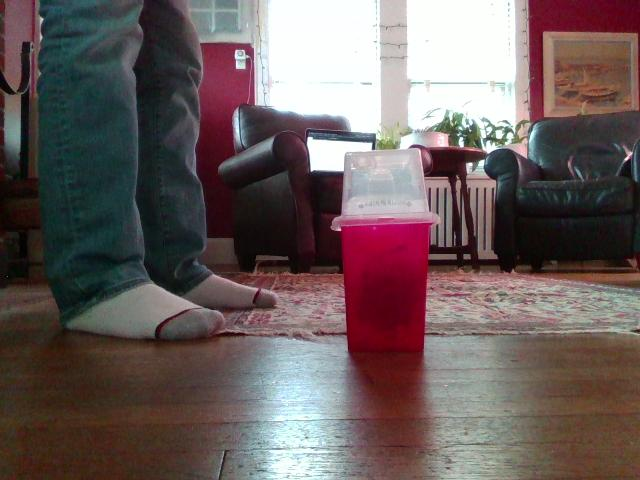

IntRangeSlider(value=(0, 179), description='Hue:', layout=Layout(width='100%'), max=179)

IntRangeSlider(value=(0, 255), description='Saturation:', layout=Layout(width='100%'), max=255)

IntRangeSlider(value=(0, 255), description='Value:', layout=Layout(width='100%'), max=255)

In [3]:
VIDEO_TIME = 10
hsv_select_live(VIDEO_TIME) # default: 10 sec

In [4]:
HSV_LOWER = np.array([164, 239, 63])
HSV_UPPER = np.array([179, 255, 178])

### 1b. <code>find_contours</code>

<p style='font-size:1.75rem;line-height:1.5'>
    This function finds and returns the contours and mask of <code>img</code>.
    </p>

In [5]:
def find_contours(img):
    # TASK #1: Convert the img to from bgr to hsv.
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # TASK #2: Mask the image using HSV_LOWER and HSV_UPPER. Save as 'mask'.
    mask = cv2.inRange(img_hsv, HSV_LOWER, HSV_UPPER)
    
    # TASK #3: Find the contours in the image. Save as 'contours'.
    contours = cv2.findContours(mask, 3, 2)[0]
    #print(contours)
    return contours, mask

### 1c. <code>check_contours_exist</code>

<p style='font-size:1.75rem;line-height:1.5'>
    This function checks that: 1. there are contours, 2. the contours are large enough.
    </p>

In [6]:
# The minimum required size of a detected contour to be considered a potential cone
EXIST_SIZE = 5

In [7]:
def check_contours_exist(contours):
    greatest_contour = None
    
    # TASK #1: If the contours list is empty, return (False, greatest_contour)
    if contours == [] or contours is None:
        print('No contours')
        return (False, greatest_contour)
    
    greatest_contour = max(contours, key = cv2.contourArea) # get largest contour
    
    # TASK #2: If the contour area of the greatest contour is smaller than 'EXIST_SIZE', return (False, greatest_contour)
    area = cv2.contourArea(greatest_contour)
    if area < EXIST_SIZE:
        print('Too small: {}'.format(area))
        return (False, greatest_contour)
    
    return (True, greatest_contour)

### 1d. Let's test our functions!

<p style='font-size:1.75rem;line-height:1.5'>
    Run the cell block below. Make sure that our function can identify the cone by drawing a bounding box around it. 
    </p>
    
<p style='font-size:1.75rem;line-height:1.5'>    
    Modify the hsv bounds from above to find the best values for your racecar. Different lighting conditions will cause the bounds to change. The better your HSV values, the better your car will run!
    </p>

In [8]:
VIDEO = True        # toggle between showing the camera video (True) or camera image (False)
VIDEO_TIME = 10    # seconds to show the video for debugging!

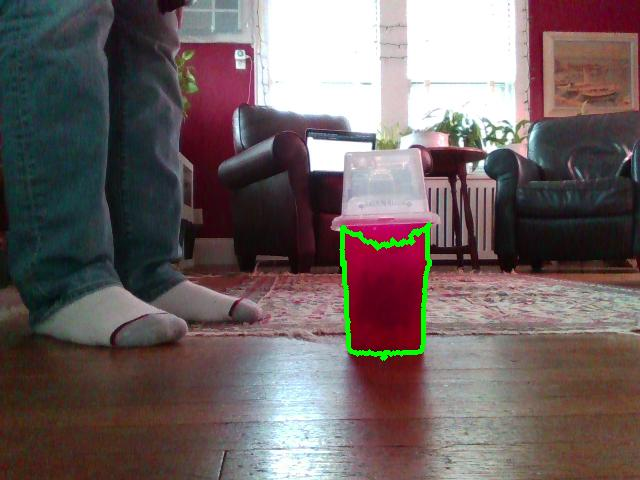

No contours


In [9]:
def identify_cone(img):
    # run student helper functions
    contours, mask = find_contours(img)
    contours_exist, greatest_contour = check_contours_exist(contours)
    if contours_exist:
        cv2.drawContours(img, [greatest_contour], -1, (0, 255, 0), 3)
    
    return img

# display image or video
if VIDEO: show_video(identify_cone, VIDEO_TIME)
else: show_image(identify_cone) 

# Part 2: Cone Following

<p style='font-size:1.75rem;line-height:1.5'>
    Now that our car can identify the cone, let us have our car follow the cone until it is one foot away from the cone. 
    </p>

### 2a. Parameters

<p style='font-size:1.75rem;line-height:1.5'>
    We have provided some useful parameters for debugging your functions:
    <ul style='font-size:1.75rem;line-height:1.5'>
        <li><code>SCREEN_CENTER (float):</code> the camera is slightly shifted. Use this to re-set the center pixel location of your output image.</li>
        <li><code>DRIVE_SPEED (float):</code> the speed of your racecar</li>
        <li><code>MIN_SIZE (int):</code> contours smaller than this value is too small, make the car drive forwards to get closer</li>
        <li><code>MAX_SIZE (int):</code> contour larger than this value is too large, make the car drive backwards to get further</li>
        <li><code>TURN_FACTOR (float):</code> how much to turn the car (in degrees)</li>
    </ul>
    </p>

In [10]:
# 2b: Fix camera offset
SCREEN_CENTER = 340    # pixel x-axis, camera is right-shifted

# 2c: get_speed
#DRIVE_SPEED = 0.215    # should be a float between 0 to 1
DRIVE_SPEED = 0.05

MIN_SIZE = 12000       # contour small, move forwards
MAX_SIZE = 30000       # contour large, move backwards

# 2d: get_angle
MAX_ERROR = 0.267         # when to start turning
TURN_FACTOR = 0.4       # max turn angle (in degrees)

### 2b. Fix the camera offset

<p style='font-size:1.75rem;line-height:1.5'>
    The camera is slightly shifted horizontally (x-axis). 
    <br> Update <code>SCREEN_CENTER</code> to re-set the center pixel location of your output image.
    </p>
    
<p style='font-size:1.75rem;line-height:1.5'>
    The function below draws a circle at <code>SCREEN_CENTER</code>. 
    <br> How to find the correct value:
    <ol style='font-size:1.75rem;line-height:1.5'>
        <li>Place an object directly in front of your camera at where you think center is.</li>
        <li>Run the two cell blocks below to test your <code>SCREEN_CENTER</code> value. </li>
        <li>Your drawn circle should be matched to the center of the object in the outputted image. </li>
    </ol>
    </p>
    
<p style='font-size:1.75rem;line-height:1.5'>
    Getting the correct <code>SCREEN_CENTER</code> value here will help you later in the the <code>get_angle</code> function.
    </p>

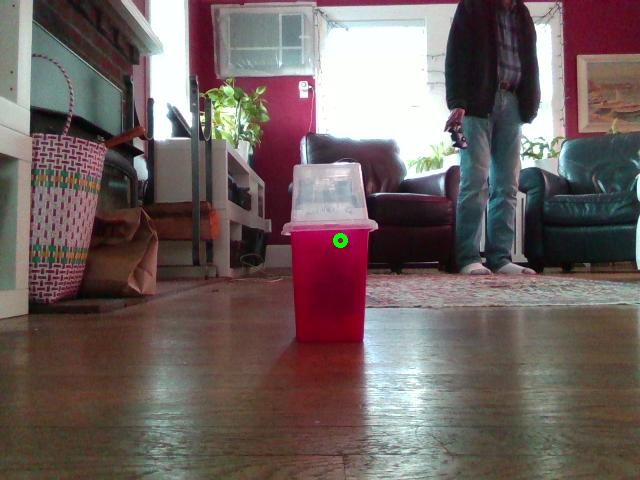

In [10]:
# mark location of SCREEN_CENTER (x-axis)
def identify_center(img):
    if SCREEN_CENTER < 0 or SCREEN_CENTER > img.shape[1]:
        print('SCREEN_CENTER out of bounds! Your image is: {}'.format(img.shape[:2]))
    cv2.circle(img, (int(SCREEN_CENTER), img.shape[0]//2), 5, (0,255,0), 3)
    return img

# display image
show_video(identify_center)

### 2c. <code>get_speed</code>

<p style='font-size:1.75rem;line-height:1.5'>
    <code>get_speed</code> determines if the car will drive forwards or backwards depending on how close the car is to the cone. 
    <br>The closer the cone, the larger the contour will be.
    </p>

<p style='font-size:1.75rem;line-height:1.5'>
    If the car is within a specific range (aka within 1 ft of the cone), then the car will not drive. 
    <br>Else it will drive forwards or backwards to get to the correct range.
    </p>

In [11]:
def get_speed(contour):
    # TASK #1: Get the contour area of 'contour'
    area = cv2.contourArea(contour)
    
    # TASK #2: If the contour area is smaller than the MIN_SIZE, set speed to DRIVE_SPEED. 
    #          If the contour area is larger than the MAX_SIZE, set speed to the -DRIVE_SPEED.
    #          If the contour area is within range, set speed to 0 (don't drive).
    if area < MIN_SIZE:
        speed = DRIVE_SPEED
        print('forwards: {}'.format(area))
    elif area > MAX_SIZE:
        speed = -1 * DRIVE_SPEED
        print('backwards: {}'.format(area))
    else:
        speed = DRIVE_SPEED
        print('parked!!!! {}'.format(area))
        
    return speed

### 2d.  <code>get_angle</code>

<p style='font-size:1.75rem;line-height:1.5'>
    Now that we have identified the cone, we have to <b>determine what angle to turn the car</b> in order to stay a certain distance away from the cone.
    </p>
    
<p style='font-size:1.75rem;line-height:1.5'>
    <code>get_angle</code> returns the turn angle of the car. We will determine whether to turn left or right, and how much to turn, depending on the location of the cone in our image. When the cone is at the center of the image, the car and cone are aligned. 
    </p>
    
<p style='font-size:1.75rem;line-height:1.5'>
    <b>Discuss with your group members some ways we might calculate the angle for the car to move.</b> 
    </p>

<p style='font-size:1.75rem;line-height:1.5'>
    <ul style='font-size:1.75rem;line-height:1.5'>
        <li>The center of the cone is found at <code>contour_center</code></li>
        <li>Calculate the offset error: 
            <br><code>error = contour_center - float(SCREEN_CENTER)</code></li>
        <li>Calculate the ratio that the cone is away from the center of the screen: 
            <br><code>ratio = error / SCREEN_CENTER</code></li>
        <li>If the absolute value of the offset error is greater than the <code>MAX_ERROR</code>, multiply <code>ratio</code> by the <code>max_angle</code> to find the return angle. </li>
    </ul>
    </p>


In [12]:
def get_angle(contour, res):
    speed, angle = res
    
    # find center of contour (aka. detected cone)
    M = cv2.moments(contour)
    if M['m00'] != 0.0:
        contour_center = int(M['m10']/M['m00'])
        ratio = 0 
        # adjust turn direction based on speed direction
        max_angle = -abs(TURN_FACTOR)     # negative
        if speed < 0:
            max_angle = abs(TURN_FACTOR)  # positive
        
        # TASK #1: Calculate the offset error
        error = contour_center - float(SCREEN_CENTER)
        
        # TASK #2: If the absolute value of the offset error is larger than MAX_ERROR
        if abs(error) > MAX_ERROR:

            # TASK #3: Calculate the ratio
            ratio = error / SCREEN_CENTER

            # TASK #4: Calculate 'angle'
            angle = ratio*max_angle

            # TASK #5: Return 'angle'
            #print(angle)
            return angle
        
    return angle

### 2f. Let's test our functions!

<p style='font-size:1.75rem;line-height:1.5'>
    Run the cell block below. Make sure that our function can identify the cone by drawing a bounding box around it. 
    </p>
    
<p style='font-size:1.75rem;line-height:1.5'>    
    Modify the hsv bounds from above to find the best values for your racecar. Different lighting conditions will cause the bounds to change. The better your HSV values, the better your car will run!
    </p>

<p style='font-size:1.75rem;line-height:1.5'>    
    Make sure to hold down the autonomous button to test your code!
    </p>
    
<p style='font-size:1.75rem;line-height:1.5'>
    <b style='color:red'>Remember to get a sticker from a TA before taking your car off the block!</b>
    </p>

In [13]:
TEST_TIME = 30

In [19]:
def withDriving(callback):
    qos_profile = QoSProfile(depth=1)
    qos_profile.history = QoSHistoryPolicy.RMW_QOS_POLICY_HISTORY_KEEP_LAST
    qos_profile.reliability = QoSReliabilityPolicy.RMW_QOS_POLICY_RELIABILITY_BEST_EFFORT
    qos_profile.durability = QoSDurabilityPolicy.RMW_QOS_POLICY_DURABILITY_VOLATILE
    publisher = rc.create_publisher(AckermannDriveStamped, '/drive', qos_profile)
    
    def drive_function(speed, angle):
        msg = AckermannDriveStamped()
        msg.drive.speed = speed
        msg.drive.steering_angle = angle
        publisher.publish(msg)
        
    callback(drive_function)
    # Send an empty message
    publisher.publish(AckermannDriveStamped())

def get_depth_speed(contour, mask, depth_img):
    masked_depth_img = cv2.bitwise_and(depth_img, depth_img, mask=mask)
    nz = np.nonzero(masked_depth_img)
    if (len(nz) == 0):
        return 0.0
    average = masked_depth_img[nz].mean()
    if (average > 1100):
        return DRIVE_SPEED
    else:
        return -1 * DRIVE_SPEED
   
def cone_follower(drive_function):
    def cone_follow(color_img, depth_img):
        speed, angle = [0.0, 0.0]
   
        # run student helper functions
        contours, mask = find_contours(color_img)
        contours_exist, greatest_contour = check_contours_exist(contours)
        if (contours_exist is True) and (cv2.contourArea(greatest_contour) > EXIST_SIZE):
            speed = get_depth_speed(greatest_contour, mask, depth_img)
            angle = get_angle(greatest_contour, (speed, angle))
            contour_area = cv2.contourArea(greatest_contour)
            cv2.drawContours(color_img, [greatest_contour], -1, (0, 255, 0), 2)
            drive_function(speed, angle)
        return color_img
   
    show_video(cone_follow, TEST_TIME, True, False)

withDriving(cone_follower)

''

No contours
No contours
No contours
No contours
No contours
No contours
Too small: 1.5
Too small: 1.5
Too small: 0.0
Too small: 0.0
Too small: 1.5
Too small: 1.5
No contours
No contours
No contours
No contours


/home/racecar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice.
/home/racecar/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
